# SVM with Kullback-Leiber Divergence Based Kernel

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from tensorflow.keras.datasets import cifar10
import pandas as pd

In [2]:
# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
# Select two classes (e.g., class 0 and class 1) and take 250 samples from each
class_0_idx = np.where(y_train == 0)[0][:250]
class_1_idx = np.where(y_train == 1)[0][:250]

In [4]:
# Concatenate the indices and select the samples
selected_idx = np.concatenate((class_0_idx, class_1_idx))
X_subset = X_train[selected_idx]
y_subset = y_train[selected_idx]

In [5]:
# Flatten the images and normalize the pixel values
X_subset_flat = X_subset.reshape(X_subset.shape[0], -1).astype('float32') / 255.0

In [6]:
# Split the data into training and test sets (80% training, 20% test)
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_subset_flat, y_subset, test_size=0.2, random_state=42)

In [7]:
# KL divergence based kernel
def kl_kernel_simple(x1, x2, A, B):
    x1 = x1.reshape(32*32, 3)
    x2 = x2.reshape(32*32, 3)

    mu1 = np.mean(x1, axis=0).reshape((3, 1))
    mu2 = np.mean(x2, axis=0).reshape((3, 1))

    cov1 = np.cov(x1, rowvar=False)
    cov2 = np.cov(x2, rowvar=False)

    try:
        cov1_inv = np.linalg.inv(cov1)
    except:
        cov1_inv = np.linalg.pinv(cov1)

    try:
        cov2_inv = np.linalg.inv(cov2)
    except:
        cov2_inv = np.linalg.pinv(cov2)

    D =  np.trace(cov1@cov2_inv) + np.trace(cov2@cov1_inv) - 2*x2.shape[1] + np.trace((cov1_inv + cov2_inv)@(mu1 - mu2)@(mu1 - mu2).T)
    K = np.exp(-A*D + B)

    return K

def kl_kernel_matrix_simple(X1, X2, A, B=0):
    gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            gram_matrix[i, j] = kl_kernel_simple(x1, x2, A, B)
    return gram_matrix

In [9]:
# example of usage of the Kullback-Leiber kernel matrix 
kl_kernel_matrix_simple(X_train_subset, X_train_subset, A=0.01)

array([[1.00000000e+00, 1.43807533e-01, 1.52777223e-05, ...,
        5.90186929e-02, 5.76587759e-02, 6.38627183e-02],
       [1.43807533e-01, 1.00000000e+00, 5.55078943e-01, ...,
        9.71534264e-01, 8.49722980e-01, 8.72160522e-01],
       [1.52777223e-05, 5.55078943e-01, 1.00000000e+00, ...,
        6.28378301e-01, 5.92194456e-02, 2.34176638e-01],
       ...,
       [5.90186929e-02, 9.71534264e-01, 6.28378301e-01, ...,
        1.00000000e+00, 8.63185519e-01, 6.57004911e-01],
       [5.76587759e-02, 8.49722980e-01, 5.92194456e-02, ...,
        8.63185519e-01, 1.00000000e+00, 5.99052485e-01],
       [6.38627183e-02, 8.72160522e-01, 2.34176638e-01, ...,
        6.57004911e-01, 5.99052485e-01, 1.00000000e+00]])

In [17]:
# Custom SVC class to use the KL kernel with parameter A
class CustomSVCKL(SVC):
    def __init__(self, A=1, C=1, **kwargs):
        super().__init__(C=C, probability=True, **kwargs)
        self.A = A

    def fit(self, X, y):
        y = y.ravel()
        self._X_fit = X
        self._gram_matrix_fit = kl_kernel_matrix_simple(X, X, self.A)
        return super().fit(self._gram_matrix_fit, y)

    def predict(self, X):
        gram_matrix_test = kl_kernel_matrix_simple(X, self._X_fit, self.A)
        return super().predict(gram_matrix_test)

    def predict_proba(self, X):
        gram_matrix_test = kl_kernel_matrix_simple(X, self._X_fit, self.A)
        return super().predict_proba(gram_matrix_test)

In [18]:
# Parameter grid for GridSearchCV
param_gridKL = {'A': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10],
              'C': [0.001, 0.005, 0.01, 0.1, 0.5, 1, 5, 10, 100]}  # Regularization parameter for SVC

# Initialize GridSearchCV with custom SVC
grid_searchKL = GridSearchCV(CustomSVCKL(kernel='precomputed'), param_gridKL, refit=True, verbose=2, cv=5)

# Fit GridSearchCV
grid_searchKL.fit(X_train_subset, y_train_subset)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END ...................................A=0.001, C=0.001; total time= 1.2min
[CV] END ...................................A=0.001, C=0.001; total time= 1.3min
[CV] END ...................................A=0.001, C=0.001; total time= 1.3min
[CV] END ...................................A=0.001, C=0.001; total time= 1.3min
[CV] END ...................................A=0.001, C=0.001; total time= 1.2min
[CV] END ...................................A=0.001, C=0.005; total time= 1.1min
[CV] END ...................................A=0.001, C=0.005; total time= 1.2min
[CV] END ...................................A=0.001, C=0.005; total time= 1.3min
[CV] END ...................................A=0.001, C=0.005; total time= 1.3min
[CV] END ...................................A=0.001, C=0.005; total time= 1.3min
[CV] END ....................................A=0.001, C=0.01; total time= 1.3min
[CV] END ....................................A=

GridSearchCV(cv=5, estimator=CustomSVCKL(),
             param_grid={'A': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10],
                         'C': [0.001, 0.005, 0.01, 0.1, 0.5, 1, 5, 10, 100]},
             verbose=2)

Best parameters found:  {'A': 0.05, 'C': 10}
Accuracy: 0.83
Precision: 0.8309323729491797
Recall: 0.8329307568438002
F1 Score: 0.8298468621759584
ROC AUC: 0.9259259259259259


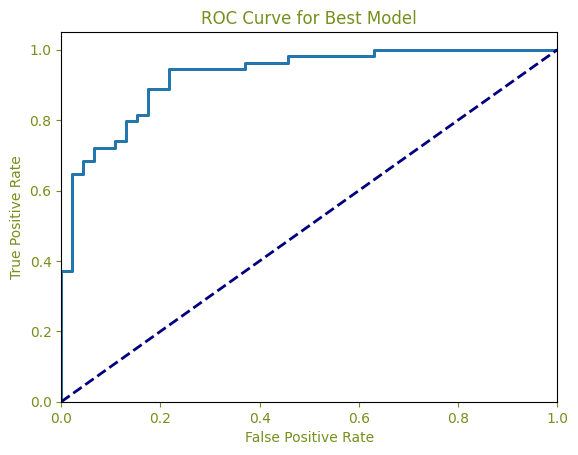

In [19]:
# Get the best parameters
best_paramsKL = grid_searchKL.best_params_
print("Best parameters found: ", best_paramsKL)

# Evaluate the best model
best_modelKL = grid_searchKL.best_estimator_
y_pred = best_modelKL.predict(X_test_subset)
y_pred_proba = best_modelKL.predict_proba(X_test_subset) if hasattr(best_modelKL, "predict_proba") else None

# Calculate metrics
accuracy = accuracy_score(y_test_subset, y_pred)
precision = precision_score(y_test_subset, y_pred, average='macro')
recall = recall_score(y_test_subset, y_pred, average='macro')
f1 = f1_score(y_test_subset, y_pred, average='macro')
roc_auc = roc_auc_score(y_test_subset, y_pred_proba[:, 1]) if y_pred_proba is not None else "Not Applicable"

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

# Plot ROC curve if probabilities are available
if y_pred_proba is not None:
    positive_class_probabilities = y_pred_proba[:, 1]
    fpr, tpr, _ = roc_curve(y_test_subset.ravel(), positive_class_probabilities)
    plt.plot(fpr, tpr, lw=2, color='#4c5454')
    plt.plot(fpr, tpr, lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', color='#74901d')
    plt.ylabel('True Positive Rate', color='#74901d')
    plt.title('ROC Curve for Best Model', color='#74901d')
    plt.tick_params(colors='#74901d')
    plt.show()

In [21]:
classification_report(y_test_subset, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.78      0.87      0.82        46\n           1       0.88      0.80      0.83        54\n\n    accuracy                           0.83       100\n   macro avg       0.83      0.83      0.83       100\nweighted avg       0.83      0.83      0.83       100\n'